<a href="https://colab.research.google.com/github/Saransh-P/Cartoonify-an-image/blob/main/Cartoonify_using_Open_CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

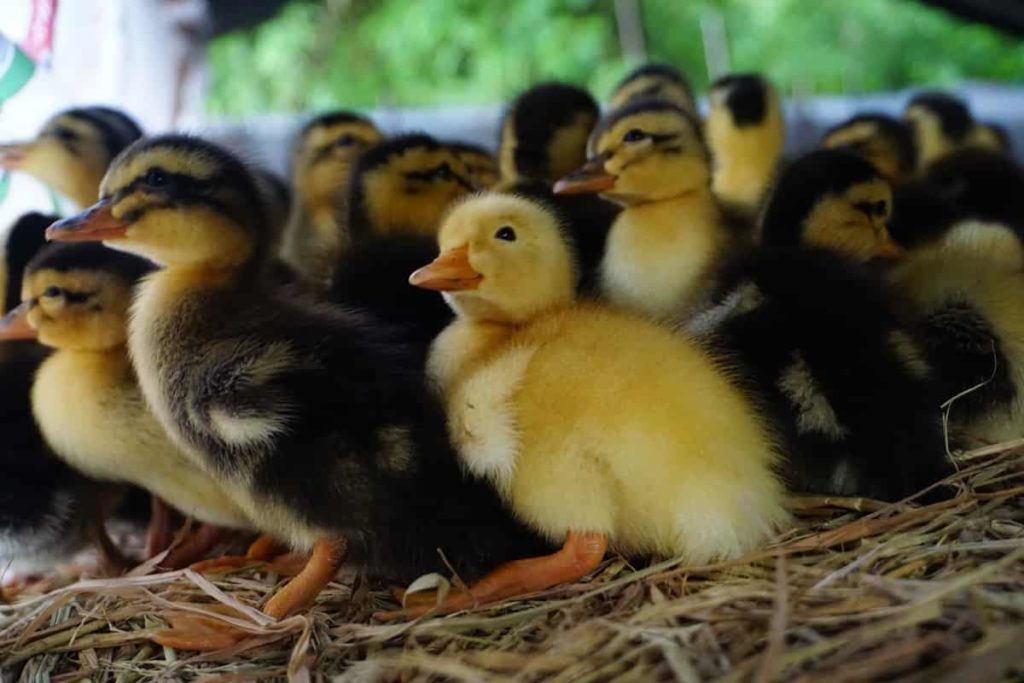

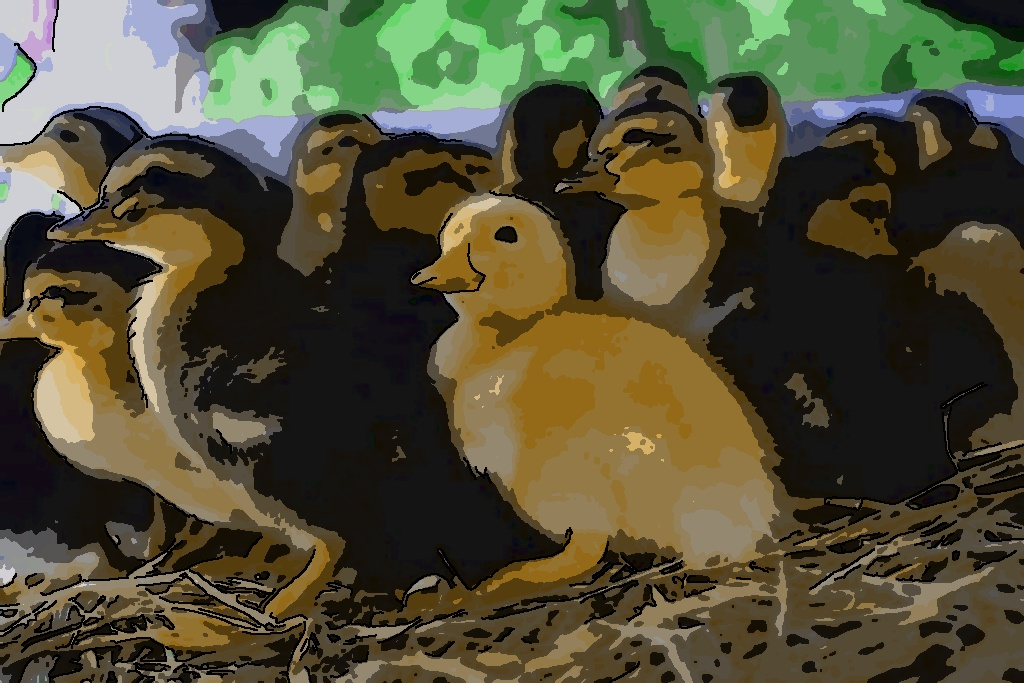

In [2]:
import cv2
import scipy
from scipy import stats
import numpy as np
from collections import defaultdict
from google.colab.patches import cv2_imshow

def update_c(C,hist):
    while True:
        groups=defaultdict(list)

        for i in range(len(hist)):
            if(hist[i] == 0):
                continue
            d=np.abs(C-i)
            index=np.argmin(d)
            groups[index].append(i)

        new_C=np.array(C)
        for i,indice in groups.items():
            if(np.sum(hist[indice])==0):
                continue
            new_C[i]=int(np.sum(indice*hist[indice])/np.sum(hist[indice]))

        if(np.sum(new_C-C)==0):
            break
        C=new_C

    return C,groups

# Calculates K Means clustering
def K_histogram(hist):

    alpha=0.001
    N=80
    C=np.array([128])

    while True:
        C,groups=update_c(C,hist)

        new_C=set()
        for i,indice in groups.items():
            if(len(indice)<N):
                new_C.add(C[i])
                continue

            z, pval=stats.normaltest(hist[indice])
            if(pval<alpha):
                left=0 if i==0 else C[i-1]
                right=len(hist)-1 if i ==len(C)-1 else C[i+1]
                delta=right-left
                if(delta >=3):
                    c1=(C[i]+left)/2
                    c2=(C[i]+right)/2
                    new_C.add(c1)
                    new_C.add(c2)
                else:
                    new_C.add(C[i])
            else:
                new_C.add(C[i])
        if(len(new_C)==len(C)):
            break
        else:
            C=np.array(sorted(new_C))
    return C

# The main controlling function
def caart(img):

    kernel=np.ones((2,2), np.uint8)
    output=np.array(img)
    x,y,c=output.shape
    for i in range(c):
        output[:,:,i]=cv2.bilateralFilter(output[:,:,i],5,150,150)

    edge=cv2.Canny(output, 100, 200)
    output=cv2.cvtColor(output,cv2.COLOR_RGB2HSV)

    hists = []

    hist,_=np.histogram(output[:,:,0],bins =np.arange(180+1))
    hists.append(hist)
    hist,_=np.histogram(output[:,:,1],bins =np.arange(256+1))
    hists.append(hist)
    hist,_=np.histogram(output[:,:,2],bins =np.arange(256+1))
    hists.append(hist)


    C=[]
    for h in hists:
        C.append(K_histogram(h))
    #print("centroids: {0}".format(C))

    output=output.reshape((-1,c))
    for i in range(c):
        channel=output[:,i]
        index=np.argmin(np.abs(channel[:, np.newaxis] - C[i]), axis=1)
        output[:,i]=C[i][index]
    output=output.reshape((x,y,c))
    output=cv2.cvtColor(output, cv2.COLOR_HSV2RGB)

    contours,_=cv2.findContours(edge,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    cv2.drawContours(output,contours,-1,0,thickness=1)
    #cartoon = cv2.bitwise_and(output, output, mask=contours)
    for i in range(3):
        output[:,:,i]=cv2.erode(output[:,:,i], kernel, iterations=1)
    #Laplacian = cv2.Laplacian(output,cv2.CV_8U, ksize=11)
    #output=output-Laplacian
    return output

output=caart(cv2.imread("Start-Duck-Farming1-1024x683.jpg"))
original = cv2.imread('Start-Duck-Farming1-1024x683.jpg')
cv2_imshow(original)
cv2.imwrite("cartoon.jpg", output)
image = cv2.imread("cartoon.jpg")
cv2_imshow(image)